In [90]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [67]:
execfile('../../matplotlibrc.py')

In [94]:
imax = 513
jmax = 257
TE_start = 65 - 1  # Trailing Edge Lower Point
TE_end = 449 - 1    # Trailing Edge Upper Point
LE = 257 - 1       # Leading Edge Point
gamma = 1.4
mach = 0.1
p0 = 1.0  # Freestream static pressure
alpha = np.deg2rad(8.0)  # Angle of Attack
Re = 3e6  # Reynolds number

SCF = 1.0/(0.5*gamma*p0*mach**2)

In [75]:
variables = ['X', 'Y', 'RHO', 'RHO-U', 'RHO-V', 'RHO-E', 'MU', 'REV', 'D2WALL']
variables = ['"%s"'%v for v in variables]
with open('tecdata.dat', 'w') as f:
    f.write(' TITLE = "PROJECT 5"\n')
    f.write(' FILETYPE = FULL\n')
    f.write(' VARIABLES = %s\n' % ' '.join(variables))
    f.write(' ZONE\n')
    f.write(' I = %i, J = %i, F=POINT\n' % (imax, jmax))
    f.write(open('NACA0012_flowfieldv2.dat').read())

In [76]:
dat = np.genfromtxt('NACA0012_flowfieldv2.dat', unpack=True)

In [77]:
def unpack(cols):
    r = []
    for col in cols:
        r.append(col.reshape((jmax, imax)).T)
    return r

In [78]:
x, y = unpack(dat[0:2,:])
w = np.empty((4, imax, jmax))
w[:] = unpack(dat[2:6])
rlv, rev, d2wall = unpack(dat[6:])
dwall = np.sqrt(d2wall)
u = w[1]/w[0]
v = w[2]/w[0]
UV = np.array([u, v])
pressure = (gamma - 1)*( w[3] - 0.5*(w[1]**2 + w[2]**2)/w[0] )
U = np.sqrt(u**2 + v**2)

In [79]:
wall = np.index_exp[TE_start:TE_end+1,0]
lower = _w(np.s_[TE_start:LE+1])
upper = _w(np.s_[LE:TE_end+1])

## Compute surface values

In [95]:
num_airfoil_nodes = TE_end - TE_start + 1
normals = np.empty((num_airfoil_nodes - 1, 2))
tangents = np.empty_like(normals)
areas = np.empty(num_airfoil_nodes - 1)
thetas = np.empty_like(areas)
xc = np.empty_like(areas)
yc = np.empty_like(areas)
cp = np.empty_like(areas)
x_wall = x[wall]
y_wall = y[wall]
p_wall = pressure[wall]
assert num_airfoil_nodes == len(x_wall)
for i in range(num_airfoil_nodes - 1):
    xc[i] = 0.5*(x_wall[i+1] + x_wall[i])
    yc[i] = 0.5*(y_wall[i+1] + y_wall[i])
    pc = 0.5*(p_wall[i+1] + p_wall[i])
    cp[i] = (pc/p0 - 1)*SCF
    dx = x_wall[i+1] - x_wall[i]
    dy = y_wall[i+1] - y_wall[i]
    l = np.sqrt(dy**2 + dx**2)
    tangents[i] = np.array([dx, dy])/l
    thetas[i] = np.arctan2(dy,dx)
    normals[i] = np.array([-dy, dx])/l
    areas[i] = l  # Assume span = 1

In [81]:
# Compute nodal stress tensor on wall
# gradUV = np.empty((num_airfoil_nodes, 2, 2))
wall2global = np.arange(airfoil.start, airfoil.stop + 1, 1)
gradUV = np.empty((2, 2))
tau_na = np.empty((num_airfoil_nodes, 2))  # tau_n and tau_a
for n in range(1, num_airfoil_nodes - 1):
    gn = wall2global[n]
    dxdi = 0.5*(x[gn+1,0] - x[gn-1,0])
    dxdj = x[gn,1] - x[gn,0]
    dydi = 0.5*(y[gn+1,0] - y[gn-1,0])
    dydj = y[gn,1] - y[gn,0]
    J = 1/(dxdi*dydj - dxdj*dydi)
    didx = J*dydj
    djdx = -J*dydi
    didy = -J*dxdj
    djdy = J*dxdi
    for k in range(2):
        dUVdi = 0.5*(UV[k,gn+1,0] - UV[k,gn-1,0])
        dUVdj = UV[k,gn,1] - UV[k,gn,0]
        gradUV[k,0] = dUVdi*didx + dUVdj*djdx
        gradUV[k,1] = dUVdi*didy + dUVdj*djdy
    
    
    mu = rlv[gn,0]
    term = (-2.0/3.0)*mu*(gradUV[0,0] + gradUV[1,1])
    tauxx = 2*mu*gradUV[0,0] + term
    tauyy = 2*mu*gradUV[1,1] + term
    tauxy = mu*(gradUV[0,1] + gradUV[1,0])
#     print gradUV, tauxx, tauyy, tauxy
    nx, ny = 0.5*(normals[n-1] + normals[n])
    
    tau_na[n,0] = nx*tauxy + ny*tauyy
    tau_na[n,1] = nx*tauxx + ny*tauxy
    
tau_nc = np.empty(num_airfoil_nodes - 1)  # Tau_n at cell center
tau_ac = np.empty_like(tau_nc)            # Tau_a at cell center
for n in range(1, num_airfoil_nodes - 1):
    tau_nc[n], tau_ac[n] = 0.5*(tau_na[n+1,:] + tau_na[n,:])
tau_nc[0], tau_ac[0] = tau_na[1]
tau_nc[-1], tau_ac[-1] = tau_na[-2]

In [96]:
tau_wc = np.empty_like(tau_nc)
cf = np.empty_like(tau_nc)
for e in range(len(tau_nc)):
#     tau_wc[e] = np.array([tau_ac[e], tau_nc[e]]).dot(tangents[e])
    t = thetas[e]
    tau_wc[e] = tau_ac[e]*np.cos(t) + tau_nc[e]*np.sin(t)
    cf[e] = tau_wc[e]*SCF

In [97]:
upper = np.index_exp[LE - TE_start:]
lower = np.index_exp[:LE - TE_start]

In [98]:
def savefig(fig, name):
    filepath = os.path.join('tex', 'figs', name)
    fig.savefig(filepath)

# Question 1

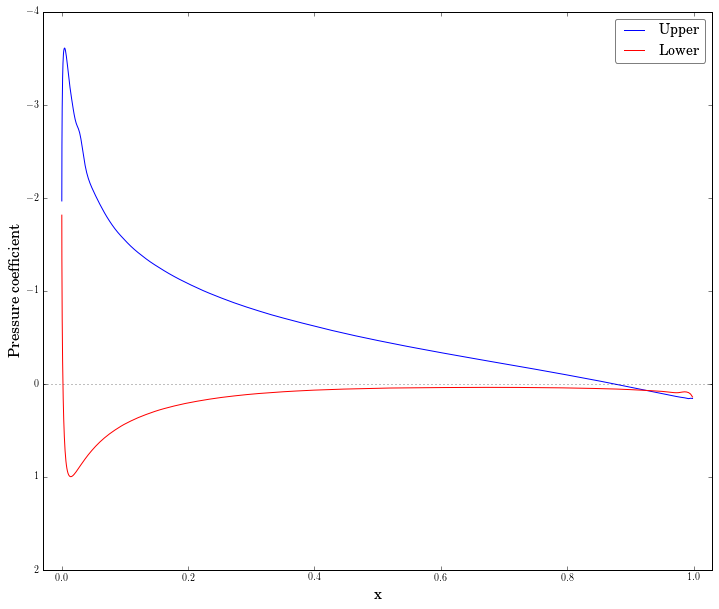

In [99]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(xc[upper], cp[upper], 'b', label='Upper')
ax.plot(xc[lower], cp[lower], 'r', label='Lower')
ax.invert_yaxis()
ax.legend()
ax.set_ylabel('Pressure coefficient')
ax.set_xlabel('x')
ax.set_xlim(-0.03, 1.03)
ax.set_yticks([0.0], minor=True)
ax.grid(True, which='minor', axis='y')
savefig(fig, 'cp.pdf')
plt.show()

## Question 2

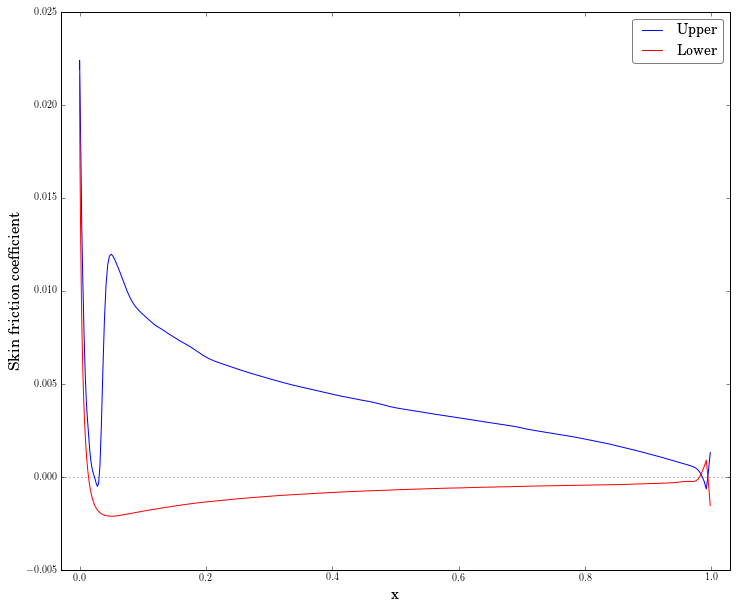

In [100]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(xc[upper], cf[upper], 'b', label='Upper')
ax.plot(xc[lower], cf[lower], 'r', label='Lower')
ax.legend()
ax.set_ylabel('Skin friction coefficient')
ax.set_xlabel('x')
ax.set_xlim(-0.03, 1.03)
ax.set_yticks([0.0], minor=True)
ax.grid(True, which='minor', axis='y')
savefig(fig, 'cf.pdf')
plt.show()

## Question 3

In [102]:
cnp = np.sum(-cp*normals[:,1]*areas)
cap = np.sum(-cp*normals[:,0]*areas)
cdp = cn*sin(alpha) + ca*cos(alpha)
clp = cn*cos(alpha) - ca*sin(alpha)

cnv = np.sum(tau_nc*areas)*SCF
cav = np.sum(tau_ac*areas)*SCF
cdv = cnv*sin(alpha) + cav*cos(alpha)
clv = cnv*cos(alpha) - cav*sin(alpha)

cd = cdp + cdv
cl = clp + clv

In [125]:
table_fmt = r'''
\begin{tabular}{@{} l ccc c ccc}
\toprule
 & \multicolumn{3}{c}{Lift} & \phantom{a} & \multicolumn{3}{c}{Drag}\\
\cmidrule{2-4}\cmidrule{6-8}
Source & Pressure & Viscous & Total && Pressure & Viscous & Total\\
\midrule
MECH 539 & %(lift)s && %(drag)s\\
Ladson & - & - & 0.8386 && - & - & 0.0079\\
\bottomrule
\end{tabular}
'''
fmt = '%.4f'
lift = ' & '.join([fmt % v for v in [clp, clv, cl]])
drag = ' & '.join([fmt % v for v in [cdp, cdv, cd]])
table = table_fmt % dict(lift=lift, drag=drag)
print(table)
open('tex/tableq3.tex', 'w').write(table)


\begin{tabular}{@{} l ccc c ccc}
\toprule
 & \multicolumn{3}{c}{Lift} & \phantom{a} & \multicolumn{3}{c}{Drag}\\
\cmidrule{2-4}\cmidrule{6-8}
Source & Pressure & Viscous & Total && Pressure & Viscous & Total\\
\midrule
MECH 539 & 0.8091 & -0.0001 & 0.8089 && 0.0048 & 0.0049 & 0.0098\\
Ladson & - & - & 0.8386 && - & - & 0.0079\\
\bottomrule
\end{tabular}



In [121]:
q = (8 - 6.05)/(8.15 - 6.05)
0.0070 + q*(0.0080 - 0.0070)

0.007928571428571429